In [2]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 3 for the experiment.


In [3]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2024-01-07 16:28:57.837400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.__version__)

2.13.0


In [5]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [6]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with 40 units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full sequence model
    model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [7]:
#Train the model
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:3'):
        seq_model= createModel(128,'adam')
        save_path = "./Saved_Models_Data/P20_U128_OA/"
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec_3.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history_3.json','w') as file:
            json.dump(history.history, file)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-07 16:29:00.246282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 model_1 (Functional)        (None, 81, 1)             131713    
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2024-01-07 16:29:04.459484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-07 16:29:04.596437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-07 16:29:04.597015: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5ba15eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 16:29:04.597037: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-01-07 16:29:04.605383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-07 16:29:04.726700: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1242/1244 [============================>.] - ETA: 0s - loss: 0.1064 - mae: 0.2173
Epoch 1: val_loss improved from inf to 0.08948, saving model to ./Saved_Models_Data/P20_U128_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 19s 13ms/step - loss: 0.1064 - mae: 0.2172 - val_loss: 0.0895 - val_mae: 0.1887
Epoch 2/200
  11/1244 [..............................] - ETA: 14s - loss: 0.0860 - mae: 0.1793

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1240/1244 [============================>.] - ETA: 0s - loss: 0.0764 - mae: 0.1549
Epoch 2: val_loss improved from 0.08948 to 0.07551, saving model to ./Saved_Models_Data/P20_U128_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0763 - mae: 0.1549 - val_loss: 0.0755 - val_mae: 0.1544
Epoch 3/200
1240/1244 [============================>.] - ETA: 0s - loss: 0.0969 - mae: 0.1948
Epoch 3: val_loss did not improve from 0.07551
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0968 - mae: 0.1947 - val_loss: 0.0876 - val_mae: 0.1746
Epoch 4/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0863 - mae: 0.1694
Epoch 4: val_loss did not improve from 0.07551
1244/1244 [==============================] - 16s 13ms/step - loss: 0.0863 - mae: 0.1694 - val_loss: 0.0798 - val_mae: 0.1661
Epoch 5/200
1243/1244 [============================>.] - ETA: 0s - loss: 0.0722 - mae: 0.1476
Epoch 5: val_loss improved from 0.07551 to 0.0628

In [8]:
import json
import matplotlib.pyplot as plt
save_path = "./Saved_Models_Data/P20_U128_OA/"
f = open(save_path+"history_3.json")
history = json.load(f)
print(len(history['loss']))

44


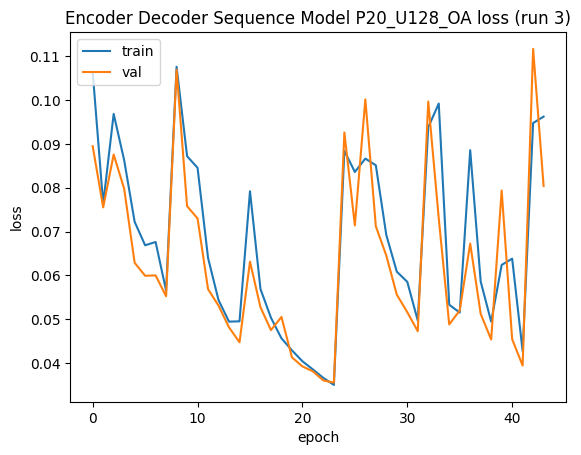

In [9]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model P20_U128_OA loss (run 3)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
#Evaluate the saved best model:
from tensorflow.keras.models import load_model
saved_model = load_model("./Saved_Models_Data/P20_U128_OA/best_enc_dec_3.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 6ms/step - loss: 0.0353 - mae: 0.0655
Mean Squared Error:  0.03532087430357933
Mean Absolute Error:  0.06554850935935974
Root Mean Squared Error (RMSE):  0.1879384854242987


In [11]:
save_path = "./Saved_Models_Data/P20_U128_OA/"

In [12]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions_3.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth_3.npy", Y_test)

389/389 [==============================] - 2s 5ms/step


In [13]:
save_path = "./Saved_Models_Data/P20_U128_OA/"
#Load the ground truth and predictions:
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path +"ground-truth_3.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.00938800722360611
Index 1 Ground truth: 0 Predicted: 0.06618528813123703
Index 2 Ground truth: 1 Predicted: 0.9037808179855347
Index 3 Ground truth: 0 Predicted: 0.0038314915727823973
Index 4 Ground truth: 0 Predicted: 1.633887450225302e-06
Index 5 Ground truth: 0 Predicted: 0.000897066667675972
Index 6 Ground truth: 0 Predicted: 0.003716508625075221
Index 7 Ground truth: 0 Predicted: 5.919992531744356e-07
Index 8 Ground truth: 0 Predicted: 2.5673820346128196e-05
Index 9 Ground truth: 0 Predicted: 0.0119598638266325
Index 10 Ground truth: 0 Predicted: 0.0007168414886109531
Index 11 Ground truth: 0 Predicted: 1.3932452702647424e-06
Index 12 Ground truth: 0 Predicted: 0.00024504357133992016
Index 13 Ground truth: 1 Predicted: 0.989762008190155
Index 14 Ground truth: 0 Predicted: 0.008506137877702713
Index 15 Ground truth: 0 Predicted: 1.5634003602826851e-07
Index 16 Ground truth: 0 Predicted: 0.007425570860505104
Inde

In [14]:
#Can convert to Benesh version for predictions using a threshold here
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh_3.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [15]:
#save the error array
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr_3.npy",err_arr)

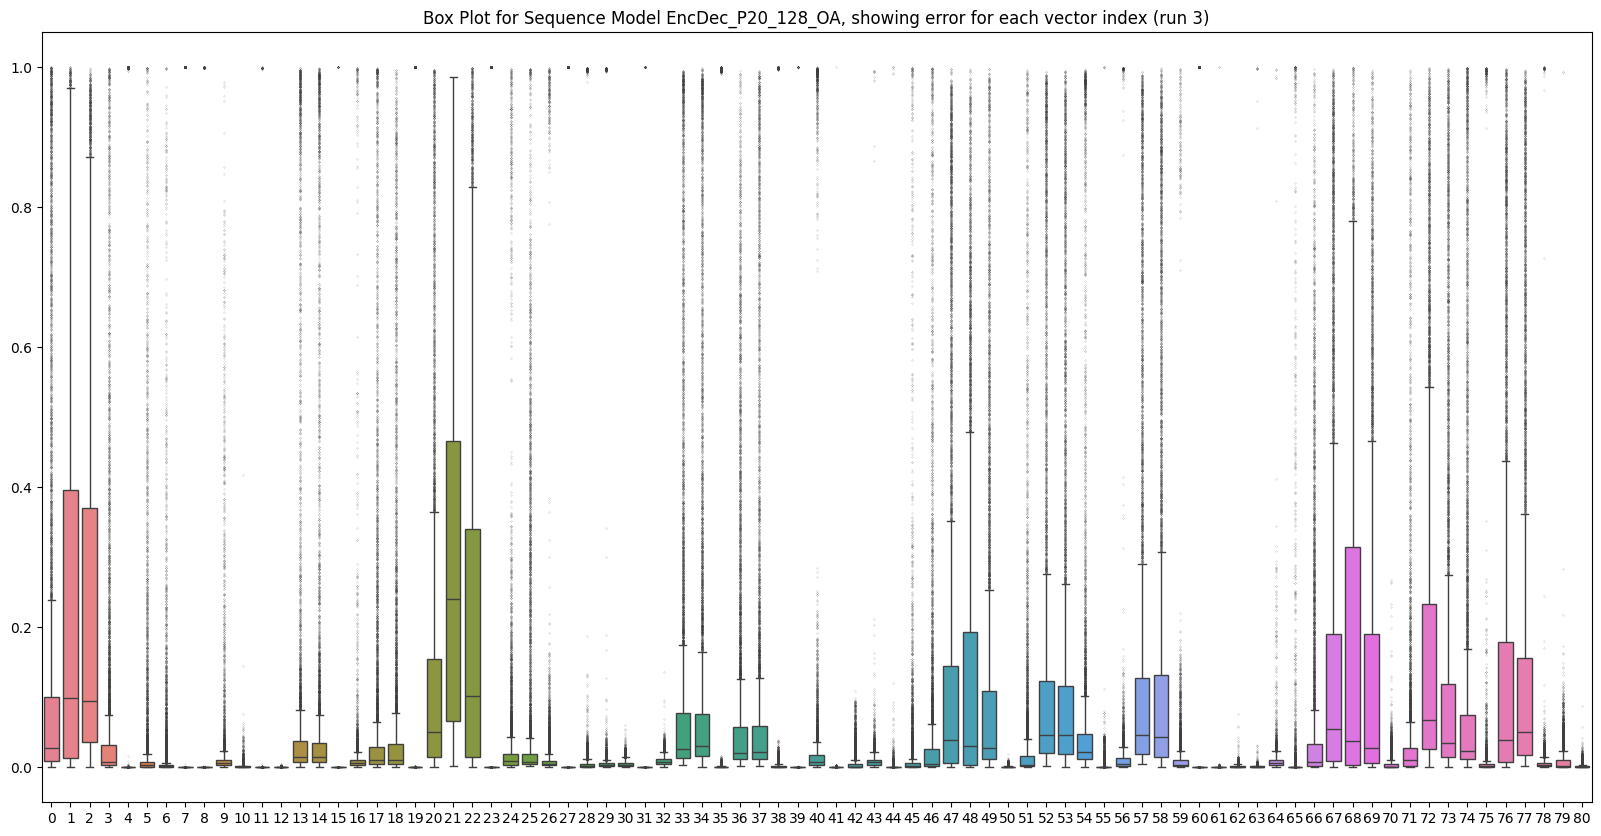

In [16]:
save_path = "./Saved_Models_Data/P20_U128_OA/"
err_arr = np.load(save_path+"err_arr_3.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec_P20_128_OA, showing error for each vector index (run 3)')
plt.show()

In [17]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100
    print("OVERALL MAPE %: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.0363365  0.05298231 0.04094803 0.04566389 0.08821767 0.03300585
 0.09562287 0.13110416 0.06924353 0.04942684]
OVERALL MAPE %:  6.55485093770694


In [18]:
from sklearn.metrics import r2_score

In [19]:
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

In [20]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.86270031 0.77884234 0.89669915 ... 0.83632986 0.69606028 0.81307971]
Overall R-squared value: 0.7201205927697832


In [21]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61237965 0.52319815 0.61237965 ... 0.60792058 0.51428    0.6034615 ]
Overall Spearman correlation coefficient: 0.5621228541362877


In [22]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.92887474 0.88263221 0.94855891 ... 0.91836511 0.83435404 0.90365621]
12433
Overall Pearson correlation coefficient: 0.8469744972983445


In [23]:
from sklearn.metrics import matthews_corrcoef
y_pred = np.load(save_path + "y_pred_benesh_3.npy")
y_true = np.load(save_path + "ground-truth_3.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.8129366858710589


In [24]:
#Save boxplot stats
import numpy as np
save_path = "./Saved_Models_Data/P20_U128_OA/"

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr_3.npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_3.csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')

12433
81
index: 0 [0.00002405 0.00836319 0.02690429 0.10085947 0.99991872]
index: 1 [0.0000043  0.01341239 0.09957415 0.39622921 0.9999486 ]
index: 2 [0.00015009 0.03584838 0.09455448 0.37041545 0.99890543]
index: 3 [0.00018395 0.00271896 0.00728253 0.0313349  0.99931108]
index: 4 [0.0000001  0.00000134 0.00000297 0.00000926 0.99999881]
index: 5 [0.00000811 0.00084581 0.00255329 0.00817312 0.99961447]
index: 6 [0.00001548 0.00058175 0.00116972 0.00282022 0.99926691]
index: 7 [0.00000003 0.00000027 0.00000047 0.00000094 0.99999972]
index: 8 [0.00000079 0.00000536 0.00001035 0.00002488 0.99998534]
index: 9 [0.0000602  0.00285209 0.00577489 0.01093511 0.97953247]
index: 10 [0.0000515  0.00054933 0.00085645 0.00126283 0.41689235]
index: 11 [0.00000015 0.00000214 0.0000144  0.00005969 0.99999708]
index: 12 [0.00000405 0.00006745 0.00015156 0.00029617 0.0051126 ]
index: 13 [0.00055991 0.00812316 0.01525056 0.03773654 0.99872351]
index: 14 [0.00046847 0.00759104 0.01437403 0.03469277 0.999133